In [24]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data loading

In [26]:
train_data = r"D:\Project\PG Project\Data\Image Data\seg_train\seg_train"
test_data = r"D:\Project\PG Project\Data\Image Data\seg_test\seg_test"

In [28]:
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [30]:
def load_data_and_extract_hog(data_dir, categories, image_size=(150, 150)):
    features = []
    labels = []
    for label, category in enumerate(categories):
        folder_path = os.path.join(data_dir, category)
        for file in tqdm(os.listdir(folder_path), desc=f"Loading {category}"):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, image_size)
            hog_feat = hog(resized, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys')
            features.append(hog_feat)
            labels.append(label)
    return np.array(features), np.array(labels)

In [32]:
X_train, y_train = load_data_and_extract_hog(train_data, categories)
X_test, y_test = load_data_and_extract_hog(test_data, categories)

Loading street: 100%|██████████| 501/501 [00:09<00:00, 55.11it/s]


### Model building

In [6]:
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

### Model saving

In [15]:
joblib.dump(svm_model, 'svm_model_1')

['svm_model_1']

In [34]:
loaded_model = joblib.load('svm_model_1')

### Classification on the test data 

In [36]:
y_pred = loaded_model.predict(X_test)

### Performance Evaluation

In [38]:
print("📄 Classification Report (SVM):")
print(classification_report(y_test, y_pred, target_names=categories,digits=6))

📄 Classification Report (SVM):
              precision    recall  f1-score   support

   buildings   0.680804  0.697941  0.689266       437
      forest   0.814532  0.900634  0.855422       473
     glacier   0.516502  0.570128  0.541991       549
    mountain   0.492308  0.489484  0.490892       523
         sea   0.631818  0.545098  0.585263       510
      street   0.767544  0.698603  0.731452       501

    accuracy                       0.644170      2993
   macro avg   0.650584  0.650314  0.649048      2993
weighted avg   0.645034  0.644170  0.643186      2993



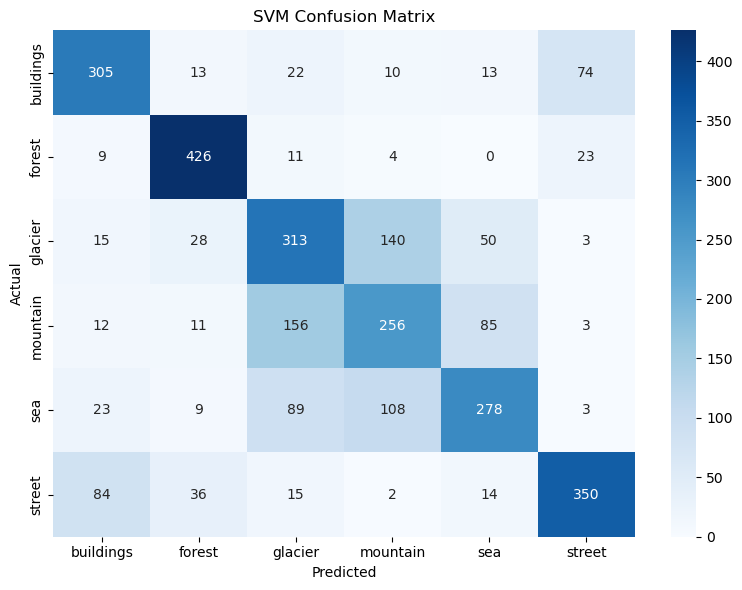

In [39]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [91]:
class_names = ['buildings', 'street']

In [93]:
def load_all_images_from_classes(test_data, class_names, image_size=(150, 150)):
    features, labels, paths = [], [], []
    for class_name in class_names:
        folder = os.path.join(test_dir, class_name)
        for filename in os.listdir(folder):
            if filename.lower().endswith(('.jpg', '.png')):
                img_path = os.path.join(folder, filename)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                resized = cv2.resize(gray, image_size)
                feat = hog(resized, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys')
                features.append(feat)
                labels.append(class_name)
                paths.append(img_path)
    return np.array(features), labels, paths

In [95]:
X_all, y_true_names, all_paths = load_all_images_from_classes(test_data, ['buildings', 'street'])

y_pred_idx = loaded_model.predict(X_all)
y_pred_names = [categories[i] for i in y_pred_idx]

In [97]:
mis_buildings, mis_street = [], []

for i in range(len(y_true_names)):
    true_class = y_true_names[i]
    pred_class = y_pred_names[i]
    if true_class != pred_class:
        if true_class == 'buildings':
            mis_buildings.append(i)
        elif true_class == 'street':
            mis_street.append(i)

mis_buildings = mis_buildings[:20]
mis_street = mis_street[:20]

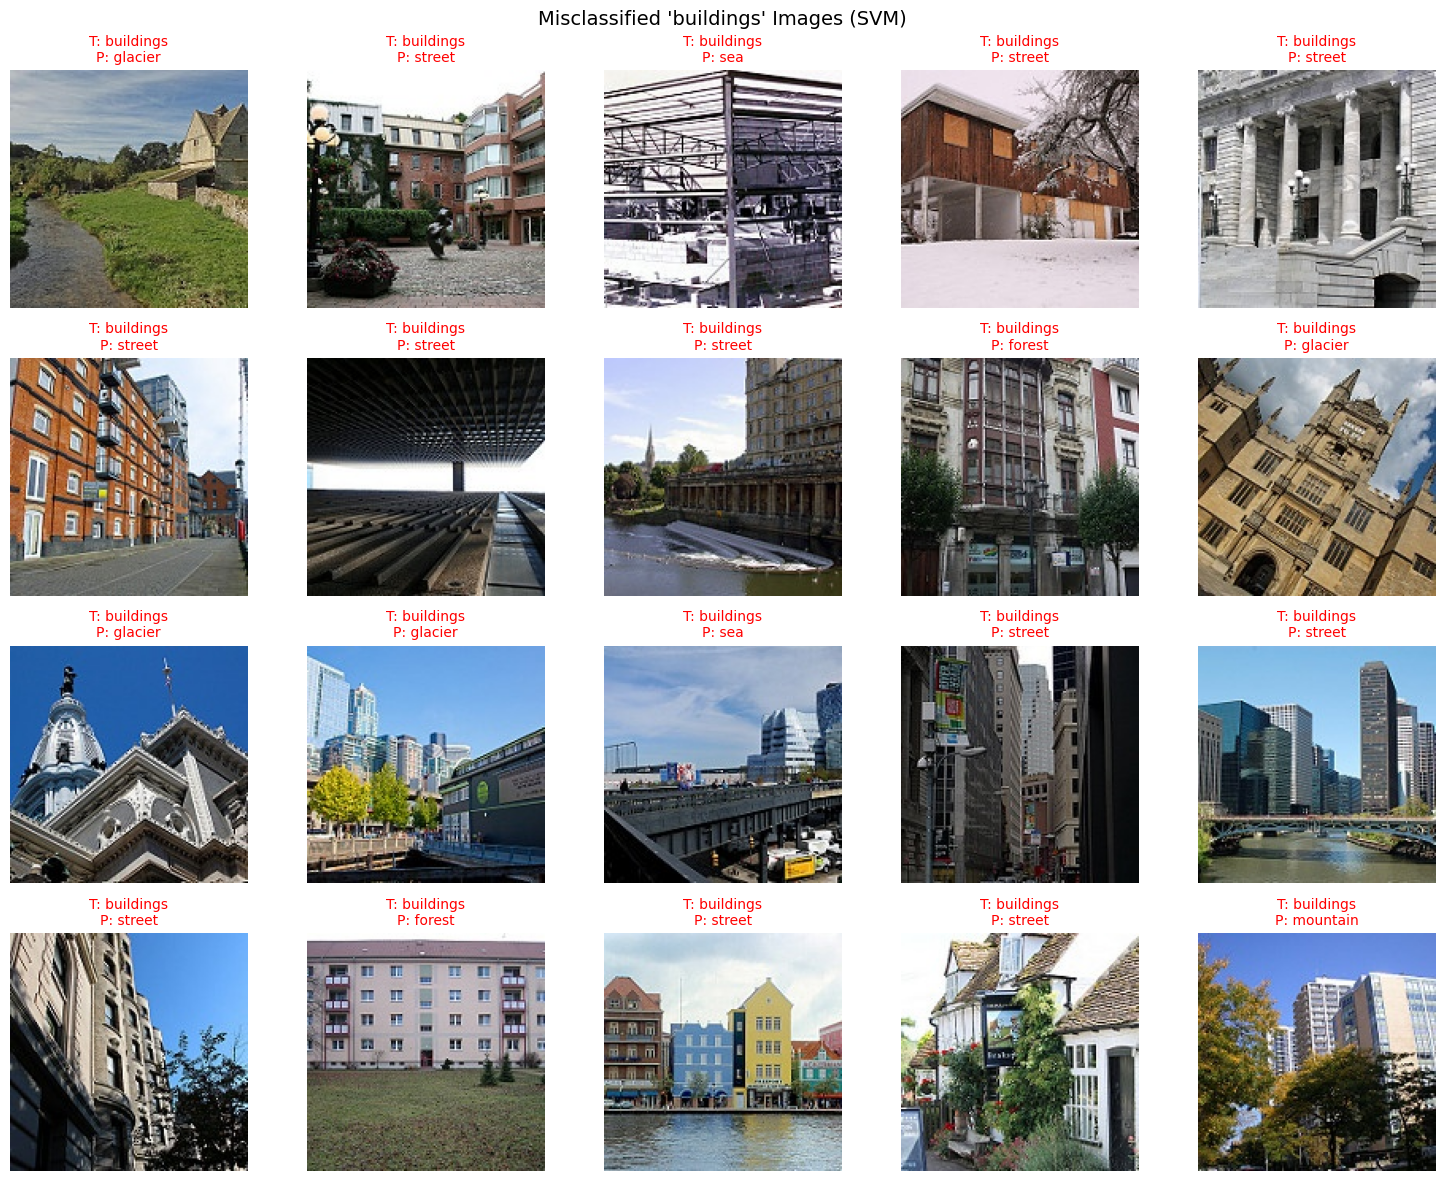

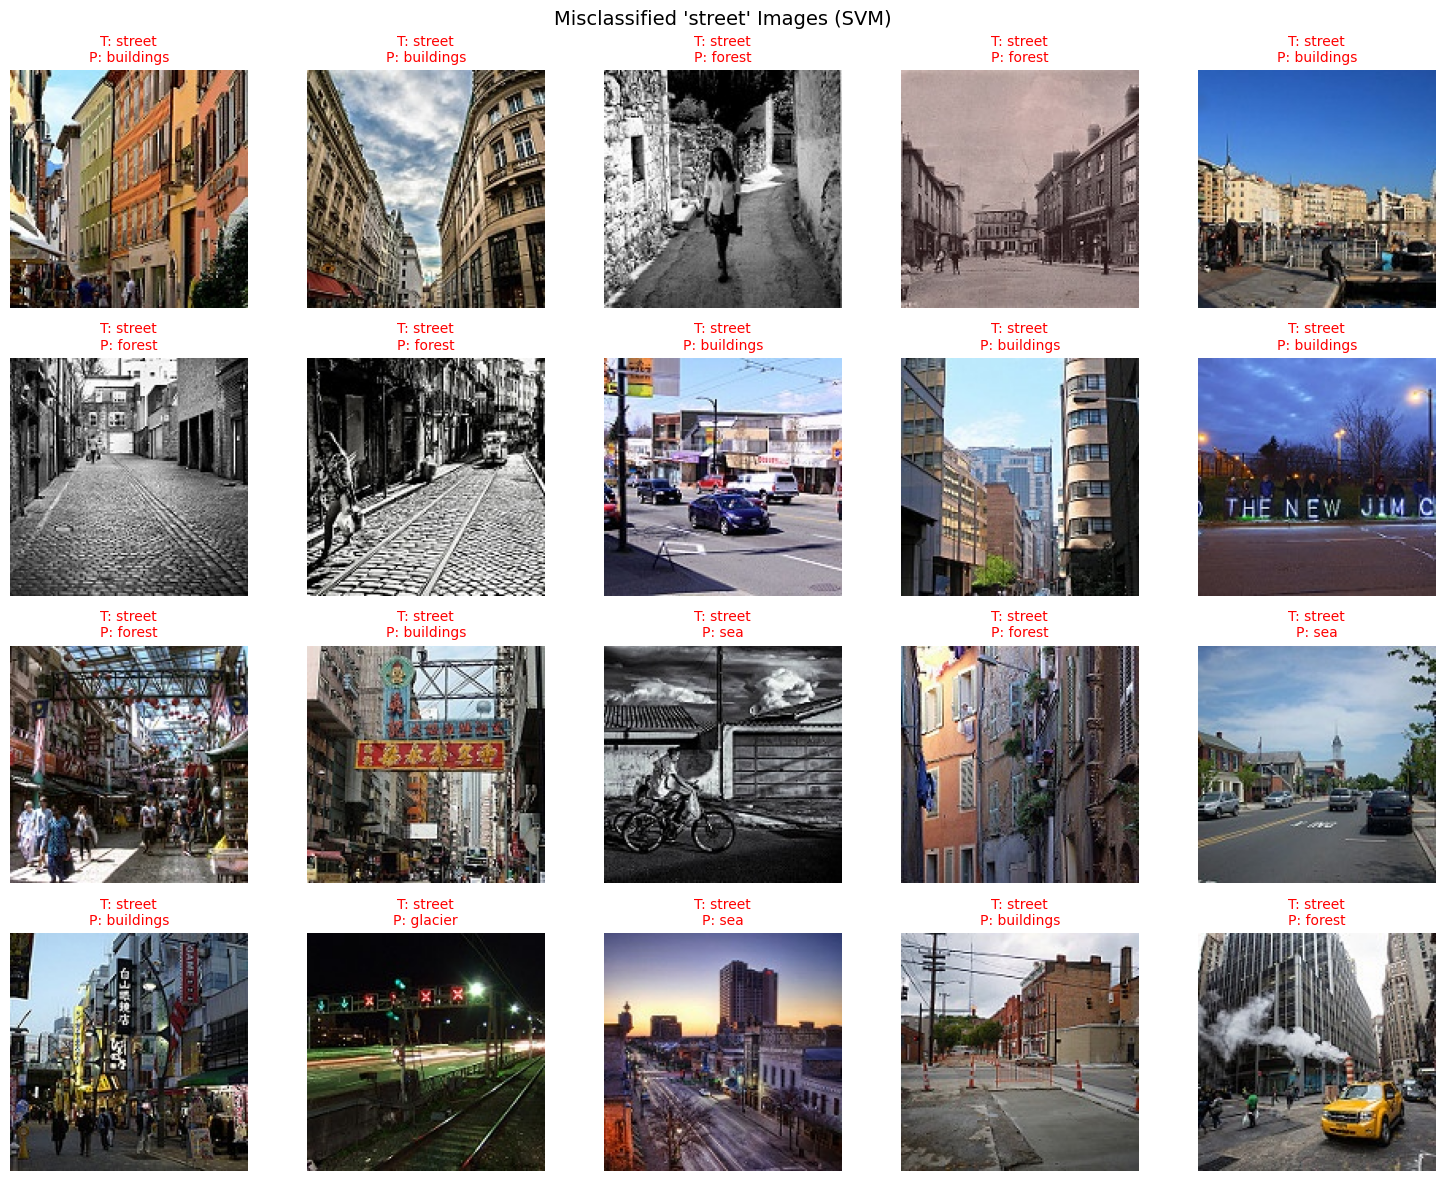

In [103]:
import math

def plot_misclassified(indices, title):
    n = len(indices)
    cols = 5
    rows = math.ceil(n / cols)
    plt.figure(figsize=(15, 3 * rows))
    for idx, i in enumerate(indices):
        img = cv2.imread(all_paths[i])
        if img is None:
            continue
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img)
        plt.title(f"T: {y_true_names[i]}\nP: {y_pred_names[i]}", color='red', fontsize=10)
        plt.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_misclassified(mis_buildings, "Misclassified 'buildings' Images (SVM)")
plot_misclassified(mis_street, "Misclassified 'street' Images (SVM)")

### Predictions on Unlabeled Images

In [111]:
def load_first_n_unlabeled_images(pred_dir, n=10, image_size=(150, 150)):
    features, paths, originals = [], [], []
    count = 0
    for filename in os.listdir(pred_dir):
        if filename.lower().endswith(('.jpg', '.png')):
            img_path = os.path.join(pred_dir, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, image_size)
            feat = hog(resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')
            features.append(feat)
            paths.append(img_path)
            originals.append(img)
            count += 1
            if count >= n:
                break
    return np.array(features), paths, originals

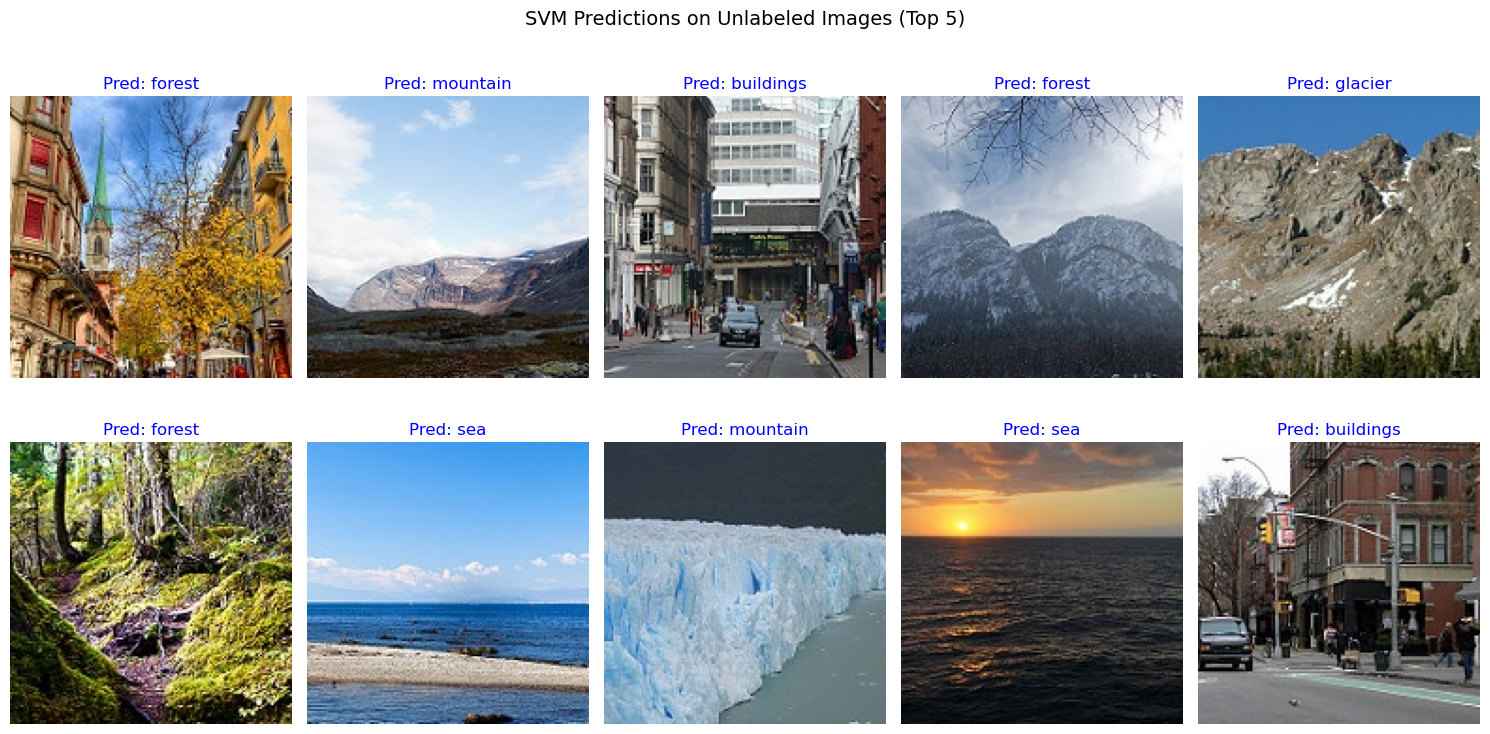

In [121]:
pred_dir = r'D:\Project\PG Project\Data\Image Data\seg_pred\seg_pred'
X_pred, pred_paths, original_images = load_first_n_unlabeled_images(pred_dir, n=10)

y_pred_idx = loaded_model.predict(X_pred)
y_pred_names = [categories[i] for i in y_pred_idx]

import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(15, 8))
for i in range(len(original_images)):
    img = original_images[i]
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {y_pred_names[i]}", color='blue', fontsize=12)
    plt.axis('off')

plt.suptitle("SVM Predictions on Unlabeled Images (Top 5)", fontsize=14)
plt.tight_layout()
plt.show()

### SVM model information

In [5]:
print("Number of support vectors (per class):", loaded_model.n_support_)
print("Support vector index:", loaded_model.support_)

支持向量数量（每类）: [1361 1107 1932 2021 1622 1360]
支持向量索引: [    0     1     2 ... 13981 13984 13985]


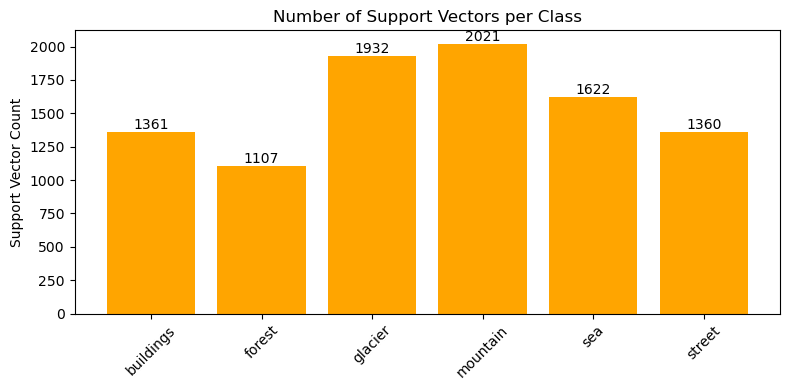

In [9]:
sv_counts = loaded_model.n_support_

plt.figure(figsize=(8, 4))
bars = plt.bar(categories, sv_counts, color='orange')
plt.title("Number of Support Vectors per Class")
plt.ylabel("Support Vector Count")
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()